# Monthly Return Analysis

## Data Gathering and Cleaning

#### Load dependencies.

In [1]:
%pylab inline

import bs4 as bs
import datetime as dt
import os
import pandas as pd
import pandas_datareader.data as web
import pickle
import requests

from matplotlib import pyplot as plt
import matplotlib as mpl

Populating the interactive namespace from numpy and matplotlib


#### Function Definitions.

In [2]:
tickers_to_load = 50
tickers = []

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})

    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        if ticker not in tickers:
            tickers.append(ticker)
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers


def get_data_from_google(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle","rb") as f:
            tickers = pickle.load(f)
    
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')

    start = dt.datetime(2000, 1, 1)
    end = dt.datetime(2016, 12, 31)
    
    for ticker in tickers[:tickers_to_load]:
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = web.DataReader(ticker, "google", start, end).groupby(pd.TimeGrouper(freq='MS'))['Close'].mean()
            df.columns = [['Date','Close']]
            df.to_csv('stock_dfs/{}.csv'.format(ticker), index_label = 'Date')
        #else:
            #print('Already have {}'.format(ticker))
            
        
        
def compile_data():
    with open("sp500tickers.pickle","rb") as f:
        tickers = pickle.load(f)

    main_df = pd.DataFrame()
    dfs = []
    
    for ticker in tickers[:tickers_to_load]:
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.columns = ['Date',ticker]
        dfs.append(df)
        
        if main_df.empty:
            main_df = df
        else:
            main_df[ticker] = df[ticker]
            
    main_df.to_csv('sp500_joined_closes.csv')

#### Create visualizations directory.

In [3]:
if not os.path.exists('visuals'):
    os.makedirs('visuals')

#### Create individual stock CSV files.

In [4]:
save_sp500_tickers()
get_data_from_google()

#### Merge CSV files.

In [5]:
compile_data()

## Plotting the Data

In [6]:
df = pd.DataFrame.from_csv('sp500_joined_closes.csv')
df.head()

,Date,MMM,ABT,ABBV,ACN,ATVI,AYI,ADBE,AMD,AAP,...,APH,APC,ADI,ANTM,AON,APA,AIV,AAPL,AMAT,ADM
0,2001-03-01,53.989545,23.176818,35.682381,15.126522,1.978182,10.375500,15.175000,24.940455,14.534500,...,16.991818,32.440000,36.833636,46.024286,56.507000,26.570909,42.951818,1.483636,23.602727,13.584091
1,2001-04-01,55.078500,23.087000,37.068947,13.737333,2.060000,11.480000,20.247500,25.255500,15.061905,...,18.591000,32.006500,36.962857,48.255500,57.436667,26.059000,43.632000,1.623000,23.944000,11.464000
2,2001-05-01,59.666364,25.070909,38.385000,15.800000,2.473636,11.310000,21.065455,30.688636,15.065789,...,24.675000,31.989545,37.295714,50.807619,57.815263,26.063636,44.840455,1.680000,26.350000,12.108636
3,2001-06-01,59.516667,25.611905,42.972727,20.345238,3.093810,12.847000,21.318571,27.553333,14.558500,...,21.334286,29.258095,39.984783,56.107895,60.286000,23.387619,47.138095,1.538095,25.487619,12.989524
4,2001-07-01,56.338571,25.209048,45.175455,25.449500,3.088095,15.052273,20.994762,20.479524,16.447727,...,20.489524,26.481429,40.138421,56.672500,60.888182,21.251429,47.904762,1.532857,22.691905,12.964762


#### Plotted prices.

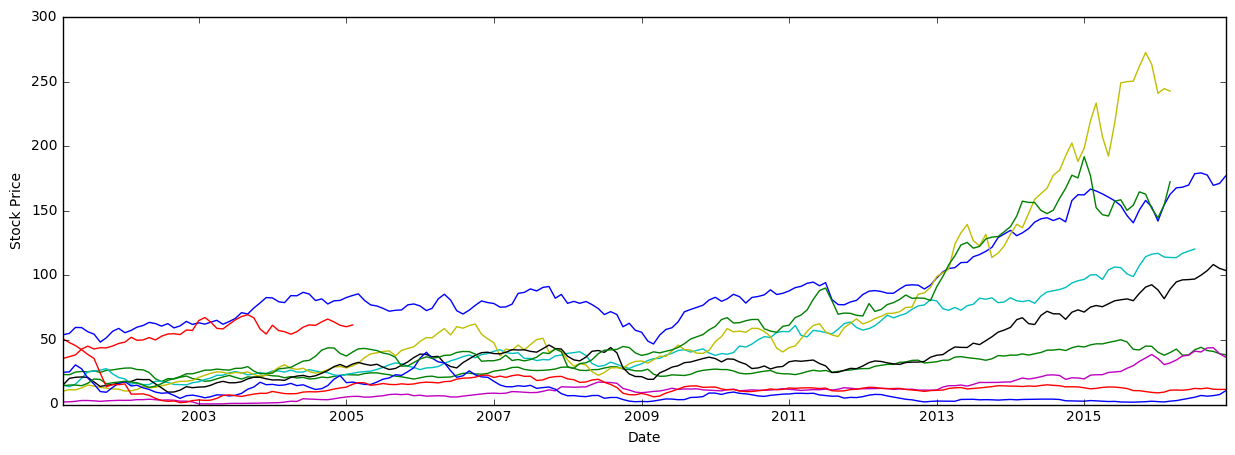

In [7]:
# set frame size
rcParams['figure.figsize'] = 15,5

# plot prices
for ticker in tickers[:10]:
    plot([dt.datetime.strptime(d,'%Y-%m-%d').date() for d in df.Date],df["{}".format(ticker)])
    xlabel("Date")
    ylabel("Stock Price")
    grid()
    
# save figure
savefig('visuals/monthly_plotted_prices.png')

### Load data for histograms. 

In [8]:
# load the first 20 tickers
num_tick = 20

titles = tickers[:num_tick]
ret_set = []

for title in titles:
    stkp = df['{}'.format(title)]
    rets = zeros(len(stkp)-1)
    for j in range(len(stkp)-1):
        rets[j] = math.log(stkp[j+1]/stkp[j])
    
    # load only non empty values
    ret_set.append(rets[~isnan(rets)])

#### Overlayed Histograms.

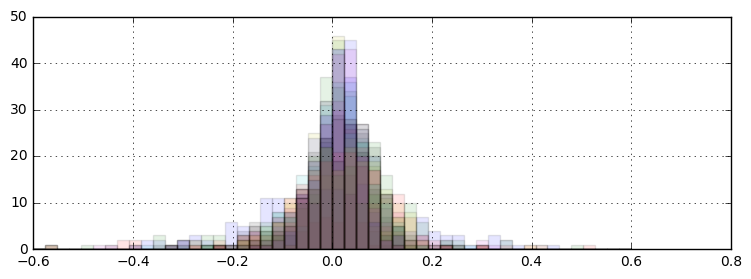

In [9]:
# set frame size
rcParams['figure.figsize'] = 9,3    

# plot
for j in arange(num_tick):
    hist(ret_set[j],50,alpha=0.1,range=[-0.6,0.6])
grid()

# save figure
savefig('visuals/monthly_overlayed_histograms.png')

#### Parallel Histograms.

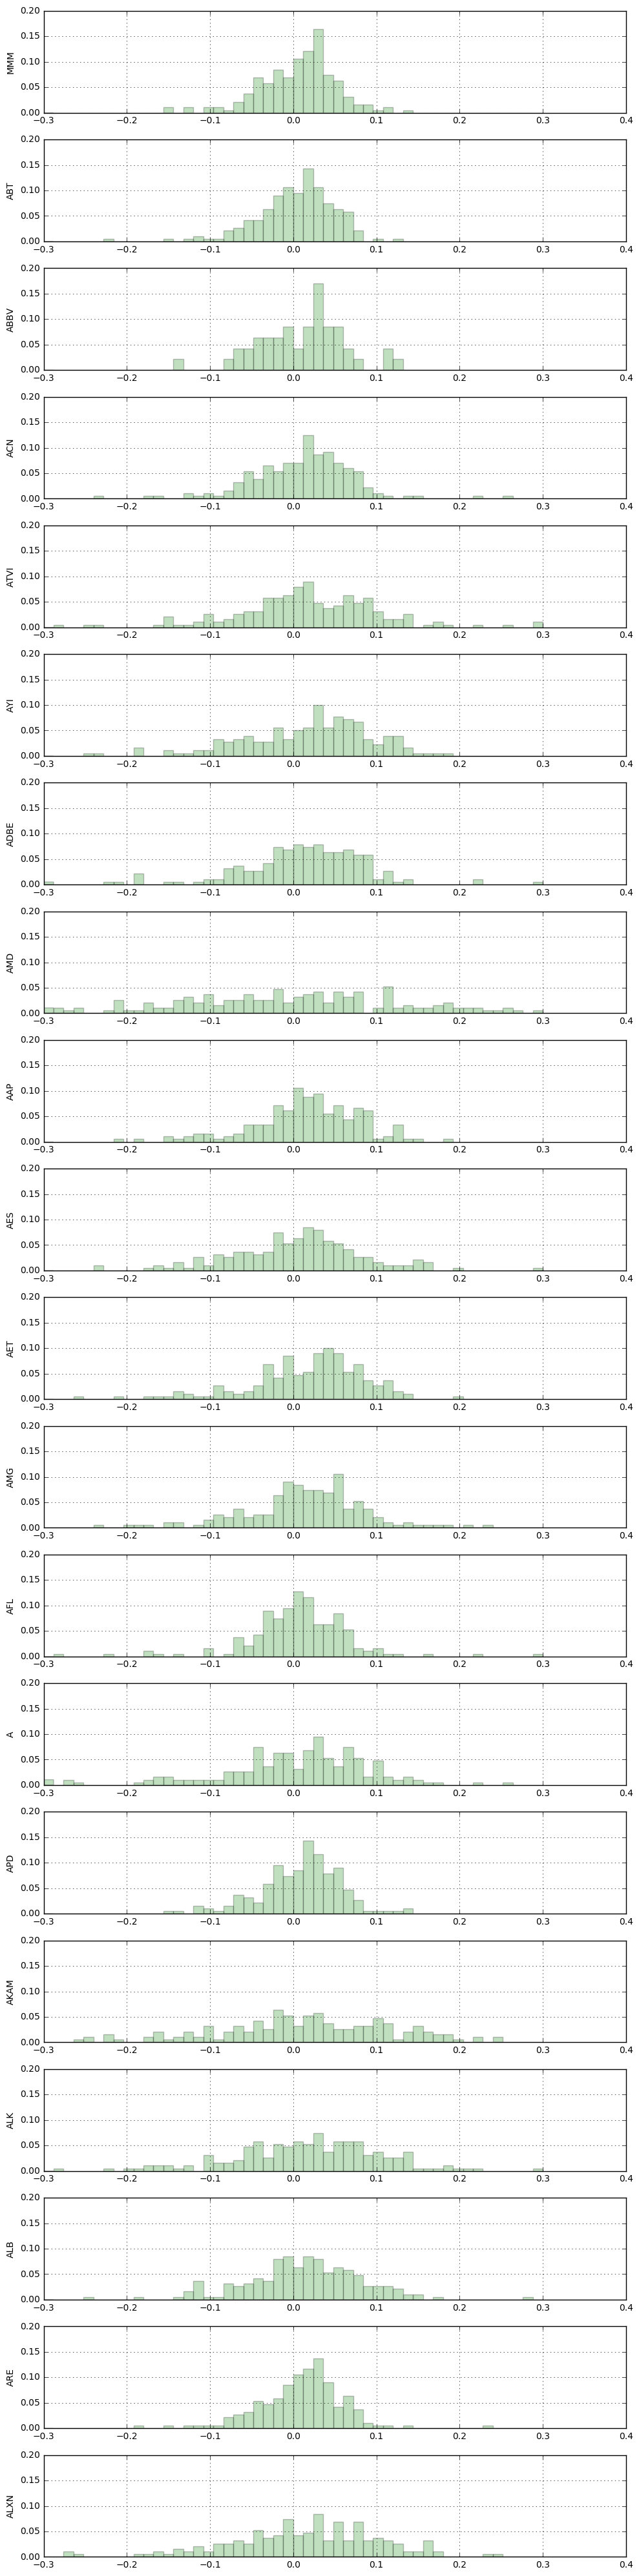

In [10]:
# set frame size
rcParams['figure.figsize'] = 10,2*num_tick

# plot 
f,a = plt.subplots(num_tick,1)
a = a.ravel()
for it,ax in enumerate(a):
    weights = np.ones_like(ret_set[it])/float(len(ret_set[it]))
    ax.hist(ret_set[it],50,color='g',alpha=0.25,range=[-0.3,0.3],weights=weights)
    ax.set_ylim([0,0.2])
    ax.set_ylabel(titles[it])
    ax.grid()

plt.tight_layout()

# save figure
savefig('visuals/monthly_parallel_histograms.png')